# Load simulated data

In [13]:
import numpy as np
import torch

from teddy.data.Alphabet import Alphabet
from teddy.data.dataset import *

alphabet = Alphabet(["A", "C", "G", "T"])
sims = MsaLabels("data/seq", alphabet)

theta, x = [], []

theta_0 = torch.Tensor(sims[0][1])
x_0 = torch.flatten(torch.Tensor(sims[0][0][0]))

for k_sim, sim in enumerate(sims):
    if k_sim == 0:
        continue
    theta.append(sim[1])
    x.append(sim[0][0])

theta = torch.Tensor(np.array(theta))
x = torch.flatten(torch.Tensor(np.array(x)), start_dim=1)

# NPE training

In [26]:
from sbi.inference import NPE

npe = NPE()
npe.append_simulations(theta, x)
npe.train()

posterior = npe.build_posterior()
samples = posterior.sample((10_000,), x=x_0)

 Neural network successfully converged after 70 epochs.

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/tj/j43hbx0j0jvcmz6tvdtf2v0c0000gn/T/ipykernel_39761/574529953.py:6: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


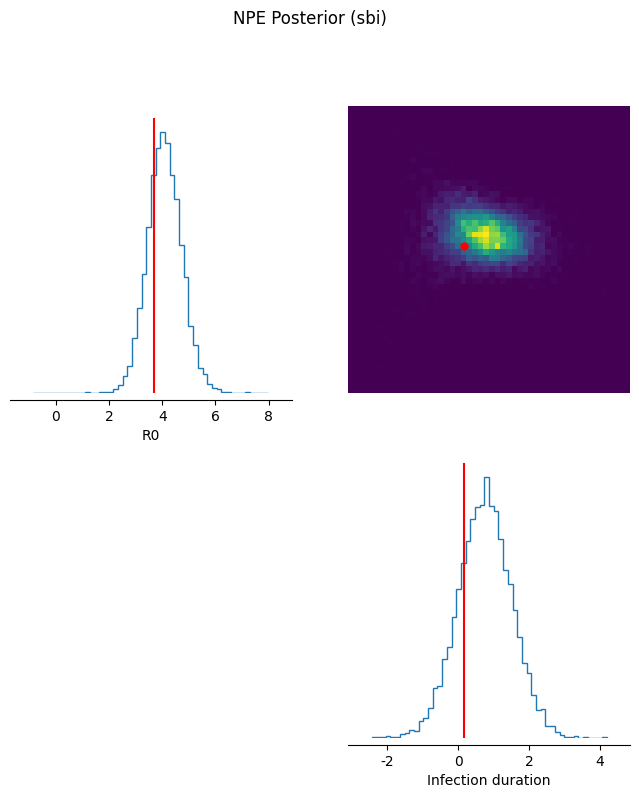

In [35]:
import matplotlib.pyplot as plt
from sbi.analysis import pairplot

param_labels = ["R0", "Infection duration"]

fig, axes = pairplot(
    samples,
    labels=param_labels,
    figsize=(8, 8),
    points=theta_0,
    points_colors="r",
)
plt.suptitle("NPE Posterior (sbi)", y=1.02)
plt.show()

In [36]:
from sbi.inference import NPE
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import FCEmbedding

embedding_net = FCEmbedding(
    input_dim=x.shape[1],
    output_dim=10,
    num_layers=2,
    num_hiddens=50
)
density_estimator = posterior_nn(model="maf", embedding_net=embedding_net)

embedding_npe = NPE(density_estimator=density_estimator)
embedding_npe.append_simulations(theta, x)
embedding_npe.train()

embedding_posterior = embedding_npe.build_posterior()
embedding_samples = embedding_posterior.sample((10_000,), x=x_0)

 Neural network successfully converged after 43 epochs.

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/tj/j43hbx0j0jvcmz6tvdtf2v0c0000gn/T/ipykernel_39761/56586445.py:6: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


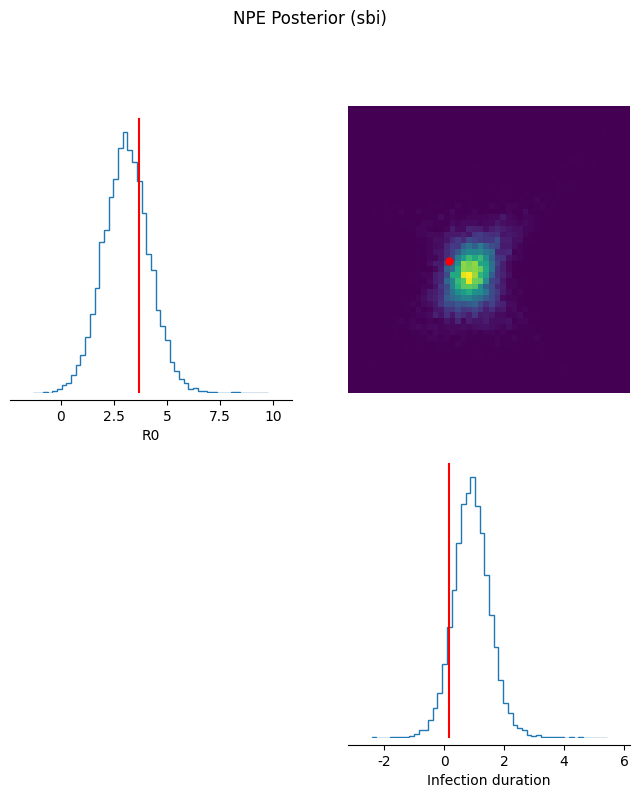

In [ ]:
import matplotlib.pyplot as plt
from sbi.analysis import pairplot

param_labels = ["R0", "Infection duration"]

fig, axes = pairplot(
    embedding_samples,
    labels=param_labels,
    figsize=(8, 8),
    points=theta_0,
    points_colors="r",
)
plt.suptitle("NPE Posterior (sbi)", y=1.02)
plt.show()

/var/folders/tj/j43hbx0j0jvcmz6tvdtf2v0c0000gn/T/ipykernel_39761/3614293860.py:6: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


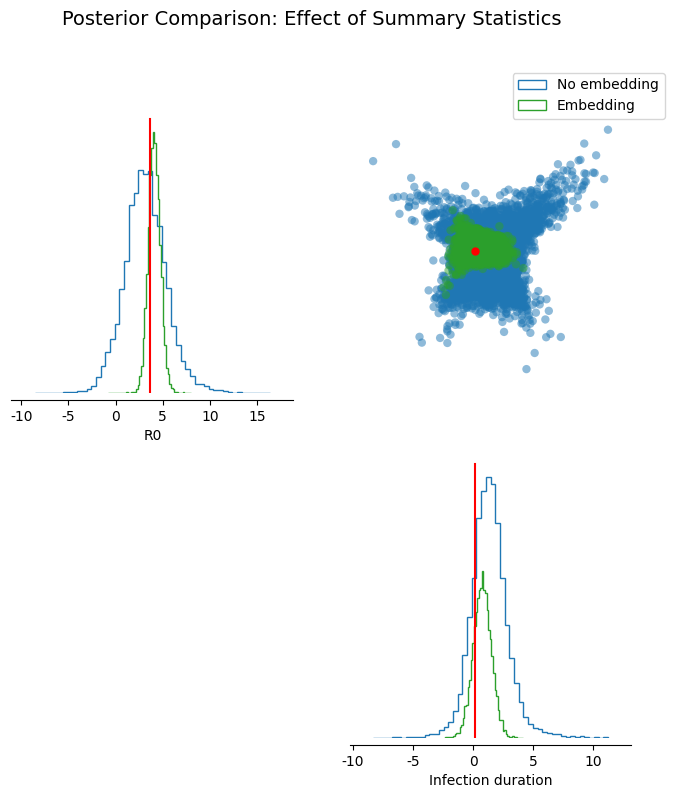

In [53]:
import matplotlib.pyplot as plt
from sbi.analysis import pairplot

param_labels = ["R0", "Infection duration"]

fig, axes = pairplot(
    [embedding_samples, samples],
    labels=param_labels,
    figsize=(8, 8),
    points=theta_0,
    points_colors="r",
    diag="hist",
    upper="scatter",
)

# Add legend manually
fig.legend(
    ["No embedding", "Embedding"],
    loc="upper right",
    bbox_to_anchor=(0.95, 0.95),
)
plt.suptitle("Posterior Comparison: Effect of Summary Statistics", y=1.02, fontsize=14)
plt.show()

In [12]:
from sbi.inference import NLE

nle = NLE()
nle.append_simulations(theta, x)
nle.train()

 Training neural network. Epochs trained: 41